In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import random
import warnings
import torch
import torch.nn as nn
import sys
import pysindy as ps
from torch.utils.data import Dataset, DataLoader, TensorDataset
from scipy.integrate import odeint
import torchdiffeq

sindy_path = '/home/sihoon/works/HAVOK/SindyPendulum_main/src'
if sindy_path not in sys.path:
    sys.path.insert(0, sindy_path)
from sindy_library import SINDyLibrary

np.random.seed(34)
warnings.filterwarnings('ignore')

# Get cpu or gpu device for training.
print(f'torch.cuda.is_available():{torch.cuda.is_available()}')
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

torch.cuda.is_available():True
Using cuda device


### Util function

In [2]:
def generate_list_increasing_by_dt(size, dt=0.1):
    output_list = []
    current_value = 0

    for _ in range(size):
        output_list.append(current_value)
        current_value += dt

    return np.array(output_list)

Data preparation

In [3]:
index_names = ['unit_number', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i+1) for i in range(0,21)]
col_names = index_names + setting_names + sensor_names


dataset_path = './Dataset/CMaps'

dftrain = pd.read_csv(os.path.join(dataset_path, 'train_FD001.txt'),sep='\s+',header=None,index_col=False,names=col_names)
dfvalid = pd.read_csv(os.path.join(dataset_path, 'test_FD001.txt'),sep='\s+',header=None,index_col=False,names=col_names)
y_valid = pd.read_csv(os.path.join(dataset_path, 'RUL_FD001.txt'),sep='\s+',header=None,index_col=False,names=['RUL'])
dfvalid.shape

train = dftrain.copy()
valid = dfvalid.copy()

print('Shape of the train dataset : ',train.shape)
print('Shape of the validation dataset : ',valid.shape)
print('Percentage of the validation dataset : ',len(valid)/(len(valid)+len(train)))

Shape of the train dataset :  (20631, 26)
Shape of the validation dataset :  (13096, 26)
Percentage of the validation dataset :  0.3882942449669404


Max time cycle found for each unit

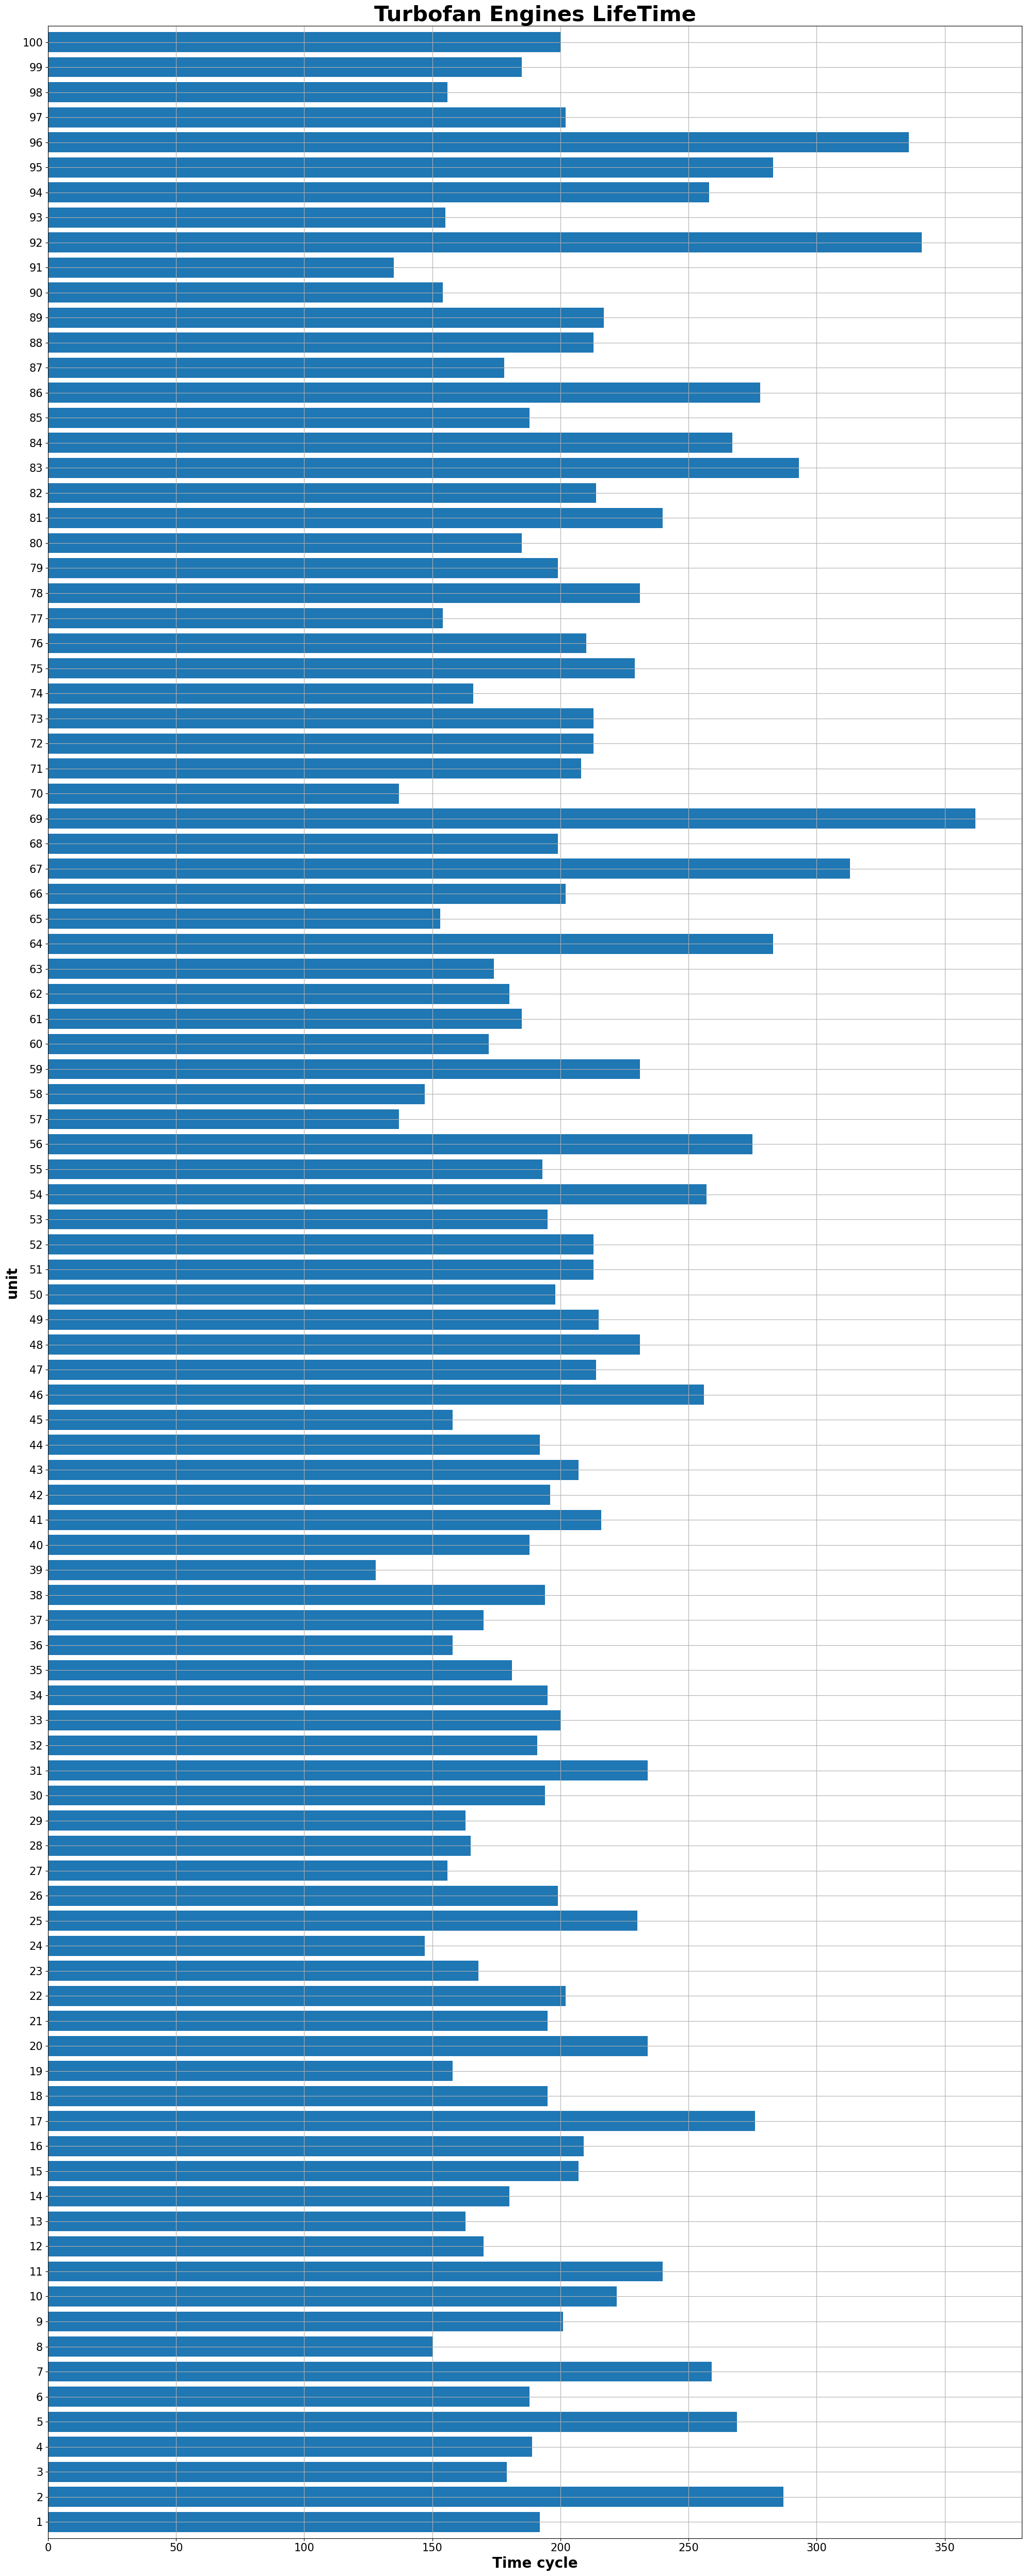

In [4]:
max_time_cycles=train[index_names].groupby('unit_number').max()
max_time_cycles
plt.figure(figsize=(20,50))
ax=max_time_cycles['time_cycles'].plot(kind='barh',width=0.8, stacked=True,align='center')
plt.title('Turbofan Engines LifeTime',fontweight='bold',size=30)
plt.xlabel('Time cycle',fontweight='bold',size=20)
plt.xticks(size=15)
plt.ylabel('unit',fontweight='bold',size=20)
plt.yticks(size=15)
plt.grid(True)
plt.tight_layout()
plt.show()

Add RUL comun to the data
RUL corresponds to the remining time cycles for each unit before it fails

In [5]:
def add_RUL_column(df):
    '''
    RUL: for each unit_number, 'max_time_cycles' denotes end of the life time.
        Thus, RUL = 'max_time_cycles' - each currnet time 'time_cycles'
    '''
    train_grouped_by_unit = df.groupby(by='unit_number') 
    max_time_cycles = train_grouped_by_unit['time_cycles'].max() 
    # print(max_time_cycles)
    # print(max_time_cycles.to_frame(name='max_time_cycle'))
    merged = df.merge(max_time_cycles.to_frame(name='max_time_cycle'), left_on='unit_number',right_index=True)
    # print(merged[['unit_number', 'max_time_cycle', 'time_cycles']])
    merged["RUL"] = merged["max_time_cycle"] - merged['time_cycles']
    merged = merged.drop("max_time_cycle", axis=1) 
    return merged

In [6]:
train = add_RUL_column(train)
train[['unit_number','RUL']]

,unit_number,RUL
0,1,191
1,1,190
2,1,189
3,1,188
4,1,187
...,...,...
20626,100,4
20627,100,3
20628,100,2
20629,100,1


In [7]:
#Rul analysis
maxrul_u = train.groupby('unit_number').max().reset_index()
maxrul_u.head()

,unit_number,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21,RUL
0,1,192,0.0047,0.0005,100.0,518.67,644.21,1605.44,1432.52,14.62,...,2388.35,8140.58,8.5227,0.03,398,2388,100.0,39.18,23.4999,191
1,2,287,0.0076,0.0006,100.0,518.67,643.94,1610.10,1431.17,14.62,...,2388.26,8175.57,8.5377,0.03,398,2388,100.0,39.24,23.6005,286
2,3,179,0.0058,0.0005,100.0,518.67,643.93,1606.50,1438.51,14.62,...,2388.20,8255.34,8.5363,0.03,399,2388,100.0,39.23,23.5181,178
3,4,189,0.0059,0.0006,100.0,518.67,644.53,1612.11,1434.12,14.62,...,2388.17,8259.42,8.5462,0.03,399,2388,100.0,39.21,23.5074,188
4,5,269,0.0055,0.0005,100.0,518.67,644.02,1609.41,1434.59,14.62,...,2388.23,8215.19,8.5410,0.03,398,2388,100.0,39.29,23.5503,268


Discoverning Correltations


             unit_number  time_cycles  setting_1  setting_2  setting_3  s_1  \
unit_number     1.000000     0.078753  -0.017895  -0.006197        NaN  NaN   
time_cycles     0.078753     1.000000  -0.004527   0.016132        NaN  NaN   
setting_1      -0.017895    -0.004527   1.000000   0.011660        NaN  NaN   
setting_2      -0.006197     0.016132   0.011660   1.000000        NaN  NaN   
setting_3            NaN          NaN        NaN        NaN        NaN  NaN   
s_1                  NaN          NaN        NaN        NaN        NaN  NaN   
s_2             0.014133     0.549898   0.009030   0.007266        NaN  NaN   
s_3             0.012621     0.543947  -0.005651   0.009068        NaN  NaN   
s_4             0.026116     0.624577   0.009544   0.014673        NaN  NaN   
s_5                  NaN          NaN        NaN        NaN        NaN  NaN   
s_6             0.026431     0.105980  -0.001340   0.014355        NaN  NaN   
s_7            -0.032073    -0.595914  -0.009437  -0

<Axes: >

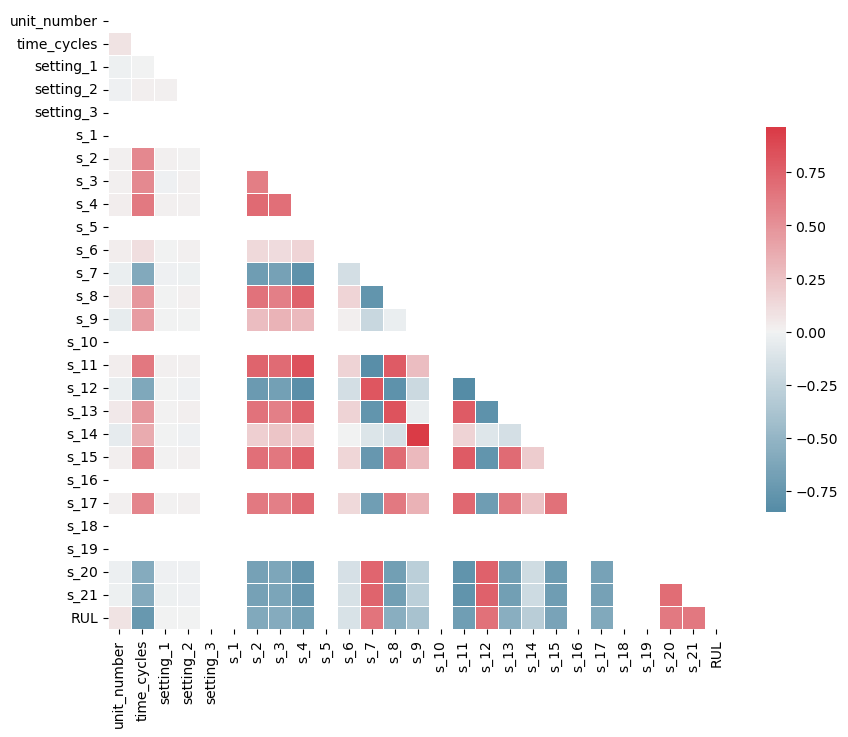

In [8]:
# Compute the correlation matrix
corr = train.corr() # 두 열 간의 상관 계수를 반환함
# 피어슨 상관계수: 
# 1: 두 변수 간 양의 선형 상관 관계, x가 증가하면 y도 증가함.
# -1: 음의 선형 상관 관계, x가 증가하면 y는 감소함.
# 0: 선형 상관관계가 없음
print(corr)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(230, 10, as_cmap=True) # maybe color
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})

Plotting the evolution of features (sensors) along with the evolution with RUL

In [9]:
Sensor_dictionary={}
dict_list=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
i=1
for x in dict_list :
    Sensor_dictionary['s_'+str(i)]=x
    i+=1
Sensor_dictionary

{'s_1': '(Fan inlet temperature) (◦R)',
 's_2': '(LPC outlet temperature) (◦R)',
 's_3': '(HPC outlet temperature) (◦R)',
 's_4': '(LPT outlet temperature) (◦R)',
 's_5': '(Fan inlet Pressure) (psia)',
 's_6': '(bypass-duct pressure) (psia)',
 's_7': '(HPC outlet pressure) (psia)',
 's_8': '(Physical fan speed) (rpm)',
 's_9': '(Physical core speed) (rpm)',
 's_10': '(Engine pressure ratio(P50/P2)',
 's_11': '(HPC outlet Static pressure) (psia)',
 's_12': '(Ratio of fuel flow to Ps30) (pps/psia)',
 's_13': '(Corrected fan speed) (rpm)',
 's_14': '(Corrected core speed) (rpm)',
 's_15': '(Bypass Ratio) ',
 's_16': '(Burner fuel-air ratio)',
 's_17': '(Bleed Enthalpy)',
 's_18': '(Required fan speed)',
 's_19': '(Required fan conversion speed)',
 's_20': '(High-pressure turbines Cool air flow)',
 's_21': '(Low-pressure turbines Cool air flow)'}

In [10]:
def subplot_signal(df, Sensor_dic):
    fig, axs = plt.subplots(7, 3,figsize=(18,30))
    
    
    for i, ax in enumerate(axs.flatten()):
        for j in df['unit_number'].unique():
            if (j % 10 == 0):   #For a better visualisation, we plot the sensors signals of 20 units only
                if i+1 in range(1, 22):
                    ax.plot('RUL', 's_'+str(i+1), data=df[df['unit_number']==j].rolling(10).mean())
                    ax.set_title('s_'+str(i+1))
                    ax.set_xlabel('RUL')
                    ax.set_xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
                    ax.set_xticks(np.arange(0, 300, 25))
    
    
    
    plt.tight_layout()
    plt.show()
    

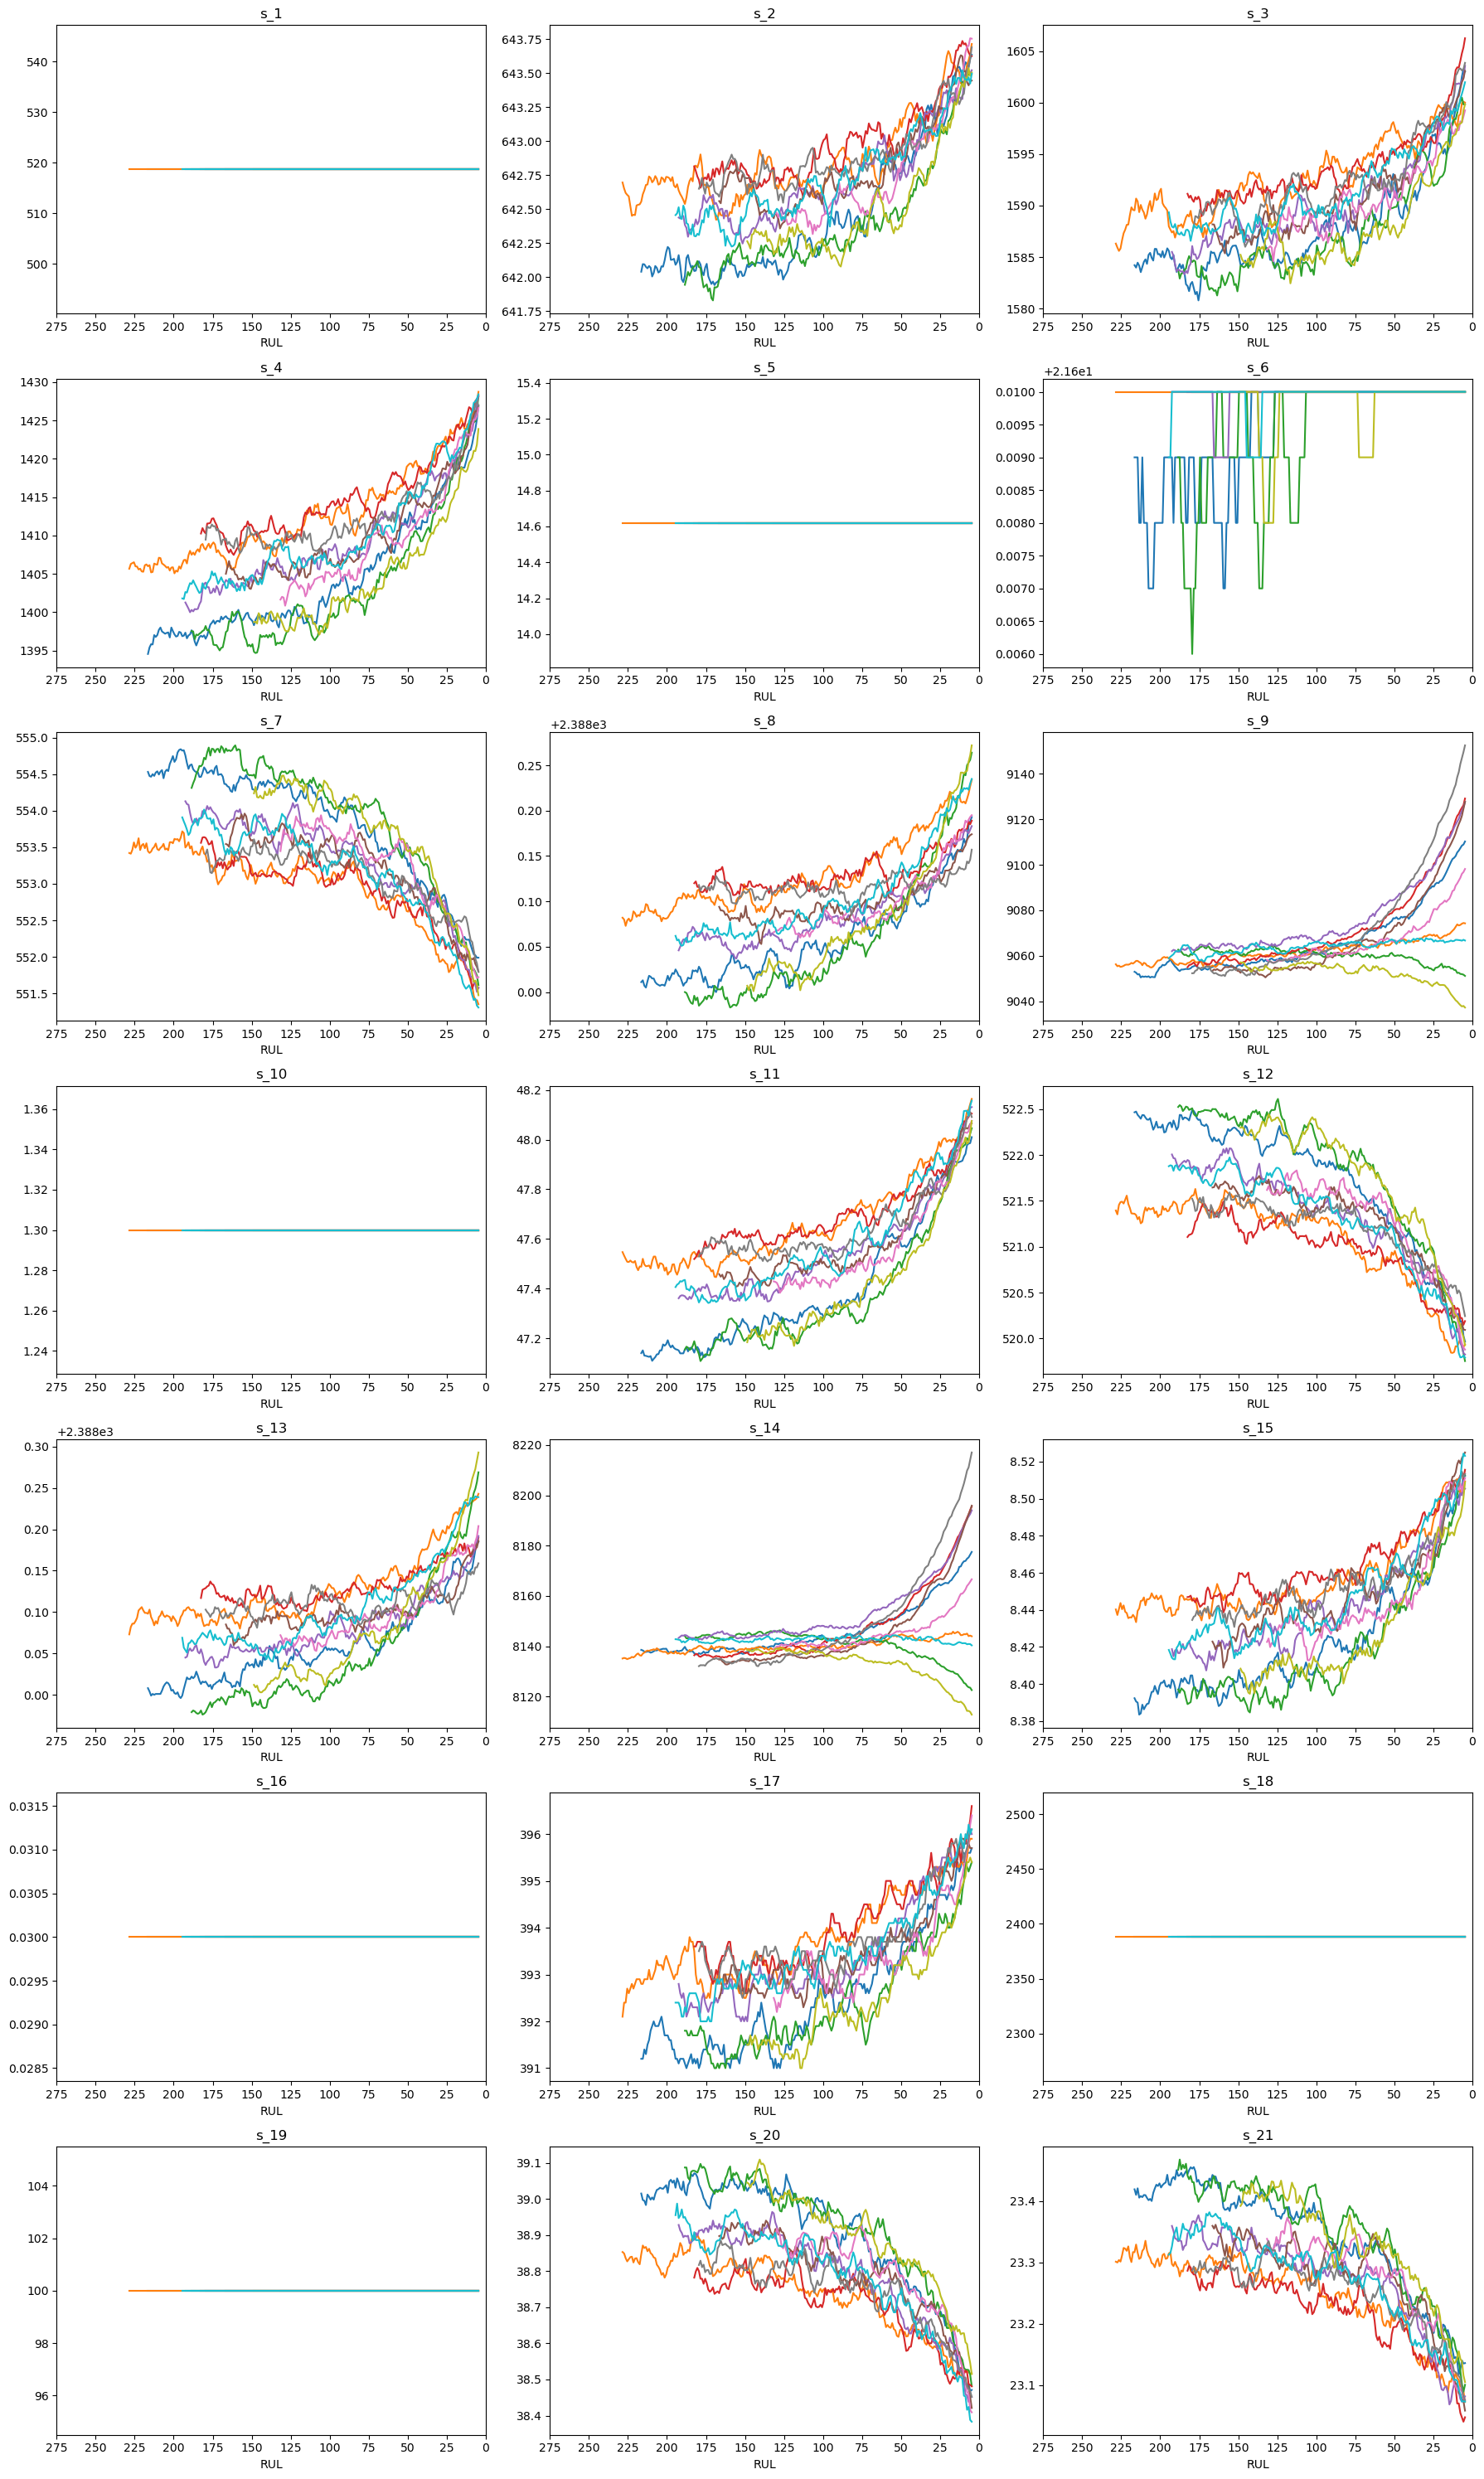

In [11]:
subplot_signal(train, Sensor_dictionary)


These plots show that some sensors are constant. Hence they don't influence the RUL ==> we can drop those ones. (later)

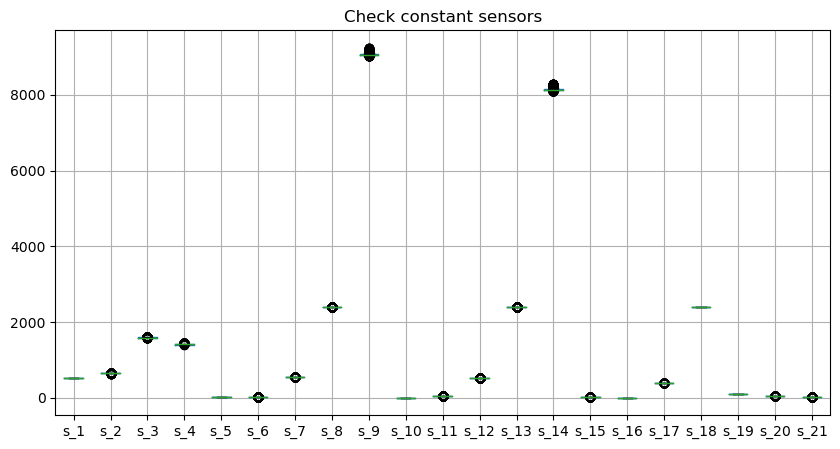

In [12]:
plt.figure(figsize=(10, 5))
train.boxplot(column=['s_'+str(i) for i in range(1,22)])
plt.title('Check constant sensors')
# plt.ylim(-0.5, 10)
plt.show()

# Network

In [69]:
class Encoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_size,128)
        self.fc2 = nn.Linear(128,64)
        self.fc3 = nn.Linear(64,32)
        self.fc4 = nn.Linear(32,latent_dim)
        self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            print(m)
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight) #per la sigmoid
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x 

class Decoder(nn.Module):
    def __init__(self, input_size,latent_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim,32)
        self.fc2 = nn.Linear(32,64)
        self.fc3 = nn.Linear(64,128)
        self.fc4 = nn.Linear(128,input_size)
        self.initialize_weights()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))   
        x = torch.relu(self.fc4(x))
        return x

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                #nn.init.xavier_normal_(m.weight)
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.1)

class Autoencoder(nn.Module):
    def __init__(self, input_size, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(input_size,latent_dim)
        self.decoder = Decoder(input_size,latent_dim)
        self.SINDyLibrary = SINDyLibrary(
            device=device,
            latent_dim=latent_dim,
            include_biases=True,
            include_states=True,
            include_sin=True,
            include_cos=False,
            include_multiply_pairs=True,  
            poly_order=2,
            include_sqrt=False,
            include_inverse=False,
            include_sign_sqrt_of_diff=False)
        

        self.XI = nn.Parameter(torch.full((self.SINDyLibrary.number_candidate_functions,latent_dim),1.,dtype = torch.float32,requires_grad=True,device = device))
#        self.XI = nn.Parameter(torch.randn((self.SINDyLibrary.number_candidate_functions,latent_dim),
        self.XI_coefficient_mask = torch.ones((self.SINDyLibrary.number_candidate_functions,latent_dim),dtype = torch.float32, device=device)

    def configure_optimizers(self):
        learning_rate = 1e-4
        return torch.optim.SGD(self.parameters(), lr=learning_rate, momentum = 0.9)
        #return torch.optim.Adam(self.parameters(), lr=learning_rate)


    def t_derivative(self,input, xdot, weights, biases, activation='sigmoid'):
        """
        Compute the first order time derivatives by propagating through the network.
        da[l]dt = xdot * da[l]dx = xdot * product(g'(w[l]a[l-1] + b[l])* w[l])
        Arguments:
            input - 2D tensorflow array, input to the network. Dimensions are number of time points
            by number of state variables.
            xdot - First order time derivatives of the input to the network. quello che conosciamo
            weights - List of tensorflow arrays containing the network weights
            biases - List of tensorflow arrays containing the network biases
            activation - String specifying which activation function to use. Options are
            'elu' (exponential linear unit), 'relu' (rectified linear unit), 'sigmoid',
            or linear.

        Returns:
            dadt - Tensorflow array, first order time derivatives of the network output.
        """
        a   = input
        dadt = xdot #per le condizioni iniziali

        if activation == 'sigmoid':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.sigmoid(z)
                gprime = a * (1-a)
                dadt = gprime * torch.matmul(dadt, weights[i].T)
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
            
        elif activation == 'relu':
            for i in range(len(weights) - 1):
                z = torch.matmul(a, weights[i].T) + biases[i]
                a = torch.relu(z)
                dadt = (z > 0).float() * torch.matmul(dadt, weights[i].T)    
            dadt = torch.matmul(dadt, weights[-1].T) #fuori dal ciclo bisogna ancora moltiplicare per i pesi dell ultimo livello
        return dadt #nel caso che ci serve dadt sará l output dell encoder ossia le latent variables!

    
    
    def compute_quantities(self,x,xdot):
    
        z = self.encoder(x)
        xtilde = self.decoder(z)

        theta = self.SINDyLibrary.transform(z) 
        zdot_hat = torch.matmul(theta, self.XI_coefficient_mask * self.XI)
        
        encoder_parameters = list(self.encoder.parameters())
        encoder_weight_list = [w for w in encoder_parameters if len(w.shape) == 2]
        encoder_biases_list = [b for b in encoder_parameters if len(b.shape) == 1]
        zdot = self.t_derivative(x, xdot, encoder_weight_list, encoder_biases_list, activation='relu')                                               

        #print("propagazione sul decoder")
        decoder_parameters = list(self.decoder.parameters())
        decoder_weight_list = [w for w in decoder_parameters if len(w.shape) == 2]
        decoder_biases_list = [b for b in decoder_parameters if len(b.shape) == 1]
        xtildedot = self.t_derivative(z, zdot_hat, decoder_weight_list, decoder_biases_list, activation='relu')    
        
        return xtilde, xtildedot, z, zdot, zdot_hat

    def loss_function(self, x, xdot, xtilde, xtildedot, zdot, zdot_hat,XI):
        mse = nn.MSELoss()
        alpha1 = 5e-4
        alpha2 = 5e-5
        alpha3 = 1e-5


        loss = {}
        loss['recon_loss'] = mse(x, xtilde) #errore di ricostruzione 
        loss ['sindy_loss_x'] = mse(xdot, xtildedot) 
        loss ['sindy_loss_z'] = mse(zdot, zdot_hat) 
        loss['sindy_regular_loss'] = torch.sum(torch.abs(XI)) #norma L1 degli XI
        loss['tot'] = loss['recon_loss'] + alpha1*loss['sindy_loss_x'] + alpha2*loss['sindy_loss_z'] + alpha3*loss['sindy_regular_loss']
        tot = loss['tot']
        return tot, loss
    
    def forward(self, x, xdot):
        return self.compute_quantities(x, xdot)
    
    
    
    def simulate(self, x0, t):
        def get_zdot(t, z):
            print(f't:{t}')
            theta = self.SINDyLibrary.transform(z) 
            zdot_hat = torch.matmul(theta, self.XI_coefficient_mask * self.XI)
            return zdot_hat
        z0 = self.encoder(x0)
        z = torchdiffeq.odeint(get_zdot, z0, t)
        print(f'z:{z.shape}')
        x = self.decoder(z)
        
        return x
        
        

Set DataLoader

In [14]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.unit_numbers = dataframe['unit_number'].unique()

    def __len__(self):
        return len(self.unit_numbers)

    def __getitem__(self, idx):
        unit_number = self.unit_numbers[idx]
        unit_data = self.dataframe[self.dataframe['unit_number'] == unit_number]
        return unit_data

# Create a DataLoader that shuffles data per 'unit_number'
def collate_fn(batch):
    return pd.concat(batch)



In [15]:
custom_dataset = CustomDataset(train)
custom_dataloader = DataLoader(custom_dataset, batch_size=10, collate_fn=collate_fn, shuffle=True)



Dropping some features (time_cycles)

In [16]:
X_train=train.drop(columns=['time_cycles']).copy()
y_train = X_train['RUL'].copy()
#Droping the target variable
X_train.drop(columns=['RUL'], inplace=True) # (14441, 21)

Data preprocessing function

In [17]:
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
window_length = 11
poly_order = 2

drop_labels = index_names+['RUL']

def preprocess(df):
    '''
    Return:
        X_train_scale:
        Xdot: 
        y_train: tensor, 
    '''
    # drop some features (unit_number, time_cycles, RUL)
    X_train=df.drop(columns=drop_labels).copy()
    y_train = df['RUL'].copy()
    
    
    # scaling
    X_train_scale = scaler.fit_transform(X_train)
    
    
    # calculate Xdot
    t_max = X_train.shape[0]
    t = generate_list_increasing_by_dt(size=t_max, dt=1)
    differentiation_method = ps.SmoothedFiniteDifference(smoother=savgol_filter, 
                                smoother_kws={'window_length': window_length, 'polyorder': poly_order})
    
    Xdot = differentiation_method._differentiate(X_train_scale, t)
    
    return torch.from_numpy(X_train_scale).to(torch.float), \
        torch.from_numpy(Xdot).to(torch.float), torch.tensor(y_train.values, dtype=torch.float)
    
    

In [18]:
input_size = len(sensor_names) + len(setting_names)
latent_dim = 5

model = Autoencoder(input_size,latent_dim).to(device)



Encoder(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=5, bias=True)
)
Linear(in_features=24, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=5, bias=True)


Model training function

In [19]:
#training step for one epoch
def train_step(loss_list):
        
    #queste serve per le loss di ogni batch
    loss_epoch = {}
    loss_epoch['recon_loss'] = []
    loss_epoch['sindy_loss_x'] = []
    loss_epoch['sindy_loss_z'] = []
    loss_epoch['sindy_regular_loss'] = []
    loss_epoch['tot'] = []
    
    model.train()
    for batch, train_batch in enumerate (custom_dataloader):
        # print(train_batch)
        X, Xdot, y = preprocess(train_batch)
        
        X = X.to(device) 
        Xdot = Xdot.to(device)
        #forward pass 
        xtilde, xtildedot, z, zdot, zdot_hat = model(X,Xdot)
        # Backpropagation
        optimizer = model.configure_optimizers()
        loss, loss_dict = model.loss_function(X, Xdot, xtilde, xtildedot, zdot, zdot_hat,model.XI)
        loss.backward()
        
        optimizer.step()
        optimizer.zero_grad()

        for key in loss_epoch.keys():
            loss_epoch[key].append(loss_dict[key].item())
        
        
    for key in loss_epoch.keys():
            loss_list[key].append(sum(loss_epoch[key])/len(loss_epoch[key]))
            
    del loss_epoch,loss_dict,xtilde, xtildedot, z, zdot, zdot_hat,loss

In [20]:
def sequential_threshold(t):
    if (t % seq_thres == 0 and t>1):
        model.XI_coefficient_mask = torch.abs(model.XI) > 0.1

def save_model(t):
    if SAVE == True:
        if t % saving_rate == 0 and t > 0:
            print('salvataggio a ',t,"epoche")
            f1 = model_path + 'model' + '_' + str(t) + 'epochs' + '.pt'
            torch.save({
            'epoch': t,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': model.configure_optimizers().state_dict(),
            'loss': model.loss_function,
            'sindy_coefficients': model.XI,
            'coefficient_mask' : model.XI_coefficient_mask
            }, f1)
            
            XI = model.XI.cpu().detach().numpy()
            np.save(model_path + 'model' + '_' + str(t) + 'epochs' + '.npy',XI)

def print_model(t):
    f = open(model_path + 'model_equation' + '_' + str(t) + '.txt', 'w')
    coefficient_mask = model.XI_coefficient_mask.cpu().detach().numpy()
    XI = model.XI.cpu().detach().numpy()
    feature_list = model.SINDyLibrary.get_feature_names()
    for j in range(latent_dim):
        for i in range(len(feature_list)-1):
            coeff = XI[i][j] * coefficient_mask[i][j]
            if  abs(coeff) >= 0.1 and coeff != 0:
                #print(f"dz{j} = {coeff:.4f} {feature_list[i]}")
                f.write(f"dz{j} = {coeff:.6f} {feature_list[i]}\n")
    f.close()

def print_loss(t):
    if t % loss_rate == 0:
        print()
        print(f"Epoch {t}\n-------------------------------")
        for key in loss_list.keys():
            temp = loss_list[key]
            print(f'{key} of epoch {t}: {temp[-1]:.3e}')

### Train

In [21]:
t = 1

VALIDATION = False
SAVE = True

epochs = 2000
model_path = './sindy_autoencoder_model/'

seq_thres = 100   # 에포크 수, 얼마 간격으로 seq thres 수행

equation_rate = 100 # 찾은 방정식 출력

saving_rate = 200 # numero epoche in cui salvo il modello e gli XI

loss_rate = 50  #print delle loss

In [22]:

loss_list = {}
loss_list['recon_loss'] = []
loss_list['sindy_loss_x'] = []
loss_list['sindy_loss_z'] = []
loss_list['sindy_regular_loss'] = []
loss_list['tot'] = []
loss_val_list = []


while t <= epochs:
    train_step(loss_list)
    
    print_loss(t)

    save_model(t)
    
    sequential_threshold(t)
    
    if t % equation_rate == 0 and t>1:
        print("epoch:",t)
        print_model(t)
        data = pd.DataFrame.from_dict(loss_list)
        data.to_csv(model_path + 'data_'+str(t)+'epochs'+'.csv')
    
    t = t + 1
print("Done!")


Epoch 50
-------------------------------
recon_loss of epoch 50: 2.386e-01
sindy_loss_x of epoch 50: 1.433e+01
sindy_loss_z of epoch 50: 1.163e+01
sindy_regular_loss of epoch 50: 1.800e+02
tot of epoch 50: 2.482e-01

Epoch 100
-------------------------------
recon_loss of epoch 100: 1.796e-01
sindy_loss_x of epoch 100: 6.859e+00
sindy_loss_z of epoch 100: 5.566e+00
sindy_regular_loss of epoch 100: 1.800e+02
tot of epoch 100: 1.851e-01
epoch: 100

Epoch 150
-------------------------------
recon_loss of epoch 150: 1.554e-01
sindy_loss_x of epoch 150: 4.858e+00
sindy_loss_z of epoch 150: 3.914e+00
sindy_regular_loss of epoch 150: 1.800e+02
tot of epoch 150: 1.599e-01

Epoch 200
-------------------------------
recon_loss of epoch 200: 1.433e-01
sindy_loss_x of epoch 200: 4.038e+00
sindy_loss_z of epoch 200: 3.302e+00
sindy_regular_loss of epoch 200: 1.800e+02
tot of epoch 200: 1.472e-01
salvataggio a  200 epoche
epoch: 200

Epoch 250
-------------------------------
recon_loss of epoch 250

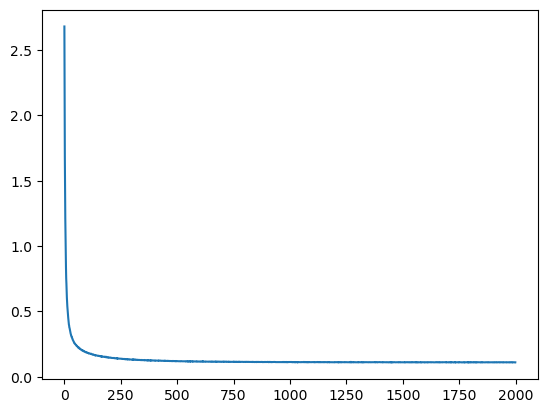

In [23]:
plt.plot(loss_list['tot'])
# plt.plot(loss_list['sindy_loss_z'])
# plt.plot(loss_list['sindy_loss_x'])
# plt.plot(loss_list['recon_loss'])
# plt.plot(loss_list['sindy_regular_loss'])



### Load trained model and simulate

In [70]:
load_model = Autoencoder(input_size,latent_dim).to(device)
t = 2000

optimizer = load_model.configure_optimizers()

f1 = model_path + 'model' + '_' + str(t) + 'epochs' + '.pt'

checkpoint = torch.load(f1)
load_model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']
# print(checkpoint['coefficient_mask'])

Encoder(
  (fc1): Linear(in_features=24, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=5, bias=True)
)
Linear(in_features=24, out_features=128, bias=True)
Linear(in_features=128, out_features=64, bias=True)
Linear(in_features=64, out_features=32, bias=True)
Linear(in_features=32, out_features=5, bias=True)


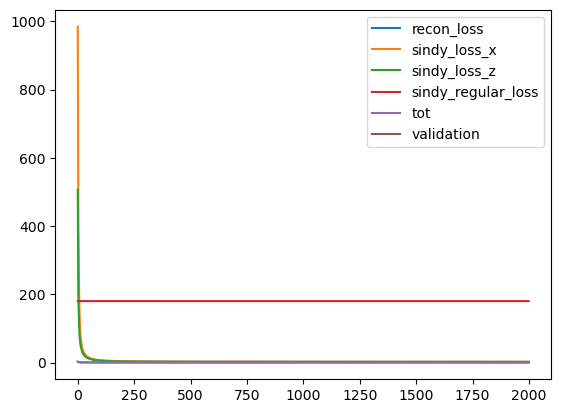

In [71]:
data = pd.DataFrame.from_dict(loss_list)
# print(data)
# data.to_csv('./data'+'_'+str(t)+'epochs'+'.csv')
for key in loss_list.keys():
    plt.plot(loss_list[key],label = key)
plt.plot(loss_val_list,label = 'validation')    
plt.legend(loc = 'best')

In [72]:
# load_model.XI_coefficient_mask
X_test_tmp = train[train['unit_number']==1]
X_test_tmp.drop(columns=drop_labels, inplace=True)

X_test_tmp_scale = scaler.fit_transform(X_test_tmp)
X_test_tmp_scale_df = pd.DataFrame(X_test_tmp_scale)

X_test_tmp_scale_smoot_df = X_test_tmp_scale_df.apply(lambda col: savgol_filter(col, window_length, poly_order))
X_test_tmp_scale_smoot = X_test_tmp_scale_smoot_df.values
X_test_tmp_scale_smoot_ts = torch.from_numpy(X_test_tmp_scale_smoot).to(torch.float)
X_test_tmp_scale_smoot_ts = X_test_tmp_scale_smoot_ts.to(device)

print(X_test_tmp_scale_smoot[:1, :].shape)
t_ts = torch.arange(0, 10, step=1, dtype=torch.float, device=device)
print(t_ts)
load_model.simulate(X_test_tmp_scale_smoot_ts[:1, :], t_ts)


(1, 24)
tensor([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], device='cuda:0')
z0:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.0
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:8.026231807889417e-05
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.0009003759478218853
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.0013505639508366585
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.0036015037912875414
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.004001670982688665
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.0045018792152404785
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.0045018792152404785
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.006213238462805748
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.007068917620927095
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.011347314342856407
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.012107918038964272
zdot_hat:torch.Size([1, 5])
z:torch.Size([1, 5])
t:0.013058670796453953
zdot_ha

AssertionError: underflow in dt 1.1576785646027135e-17